# Evolution of actors careers post-blockbuster in the film industry
How does a significant box office success impact an actor's subsequent choices and overall career path ?

##  Context

Analyze career trajectories of actors following their roles in high-grossing films using the CMU Movie Dataset

More specifically, explore the following research questions: 
- Does a high-grossing film consistently lead to **continued box office success** for its actors in their subsequent films?
- Is there a noticeable **change in genre or type of characters** portrayed by actors after a significant hit?
- What are the long-term career impacts on actors who have starred in blockbuster hits?

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


## 1. What is a big hit? :
We now have to define what makes a movie a big hit? We will focus on revenue as mentioned eariler but now that we have the IMDb ratings we can also use this information to define a big hit (i.e. a very successful movie). We will consider the product of the movie revenue with its average IMDb rating as a metric for success.

Let's look at the evolution of this metric along the years.

In [2]:
%store -r character_movies_filtered_imdb
%store -r nb_tot_filtered_actors


In [3]:
# Make deep copy of our prepared dataset
df_prepared = character_movies_filtered_imdb.copy()

In [4]:
# Add a column to our dataset for this new success metric
df_prepared['success'] = df_prepared.revenue * df_prepared.averageRating

[]

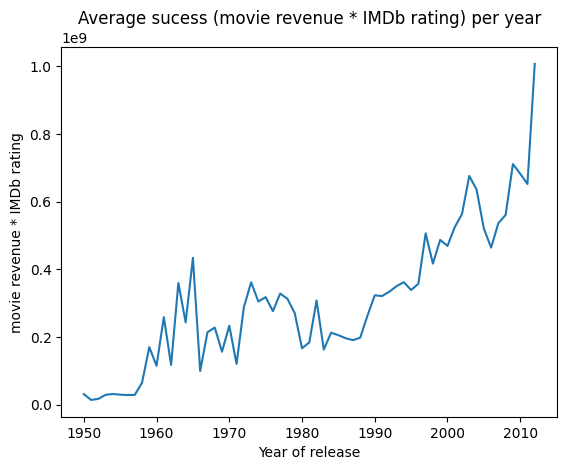

In [5]:
# Get the mean and standard deviation of the success metric for each year
unique_movies = df_prepared.drop_duplicates(subset = 'movieID')

success_per_year = unique_movies.groupby(by = 'year')['success']

avg_success_per_year = success_per_year.mean()
std_success_per_year = success_per_year.std()

# Plot the results
plt.plot(avg_success_per_year)
#plt.fill_between(avg_revenue_per_year.index, (avg_revenue_per_year+std_revenue_per_year).values,
#                 (avg_revenue_per_year-std_revenue_per_year).values, color='lightblue')
plt.title('Average sucess (movie revenue * IMDb rating) per year')
plt.ylabel('movie revenue * IMDb rating')
plt.xlabel('Year of release')
plt.plot()

From this graph we can see a certain fluctuation in the average movie revenue per year.

To keep things simple we will assume that for a movie to be a big hit it has to be an outliner with respect to our previously defined success metric. We will pick only the outliners of each year and label them as big hits. We define an outliner as: outlier's success metric > Q3 + 1.5*(IQR) where Q1, Q3 and IQR are respectively the first quantile, the third quantile and the interquantile range.

The number of big hits is: 653


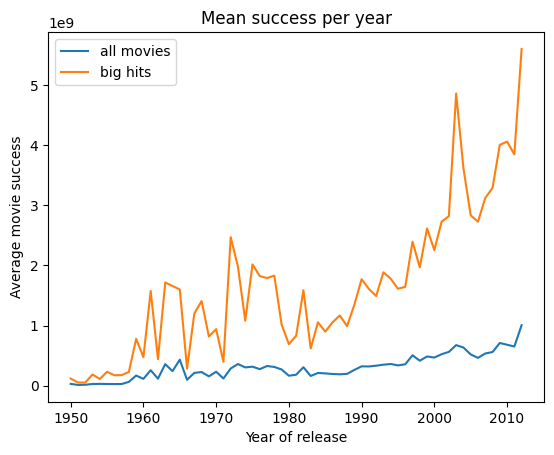

In [6]:
# Compute the first and the third quantile for each year
Q1 = success_per_year.quantile(q=0.25)
Q3 = success_per_year.quantile(q=0.75)

# Compute our ouliner threshold value for each year
outliner_thresh = Q3 + 1.5 *(Q3-Q1)
outliner_thresh.name = 'threshold'

# Filter movie dataset to keep only the big hits
movies_merged = pd.merge(df_prepared, outliner_thresh, left_on='year', right_index=True)
big_hits = movies_merged[movies_merged['success'] > movies_merged['threshold']]

# Plot the mean revenue for big hits compaired to the mean revenue for all movies per year
unique_movie_hits = big_hits.drop_duplicates(subset = 'movieID')
success_hits_per_year = unique_movie_hits.groupby(by = 'year')['success'].mean()

plt.plot(avg_success_per_year, label = 'all movies')
plt.plot(success_hits_per_year, label = 'big hits')

# Add labels
plt.title('Mean success per year')
plt.ylabel('Average movie success')
plt.xlabel('Year of release')
plt.legend()
plt.plot()

# How many big hits do we have?
print(f'The number of big hits is: {len(unique_movie_hits)}')

Do we have enough data? If not: change the ouliner definition or change big hit definition

Now let's divide our actors dataset into the ones that have played in one of those big hits (treatement group) and the ones that did not (control)

In [7]:
# Get a set with the names of the actors that played in a big hit
unique_actor_hits = big_hits.drop_duplicates(subset = 'name_actor').name_actor

# Creat a new column on our main dataframe, a bool for wheter the actors played in a big hit or not
df_prepared['big_hit_actor'] = df_prepared.name_actor.isin(unique_actor_hits)

# Get a dataframe of actors that played in a big hit (treatement group)
actors_big_hit = df_prepared[df_prepared.big_hit_actor]
# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = df_prepared[~df_prepared.big_hit_actor]

# Print the number of actors in each group
nb_big_hit_actors = len(unique_actor_hits)

print(f'The number of actors that played in a big hit is: {nb_big_hit_actors} (treatement group)')
print(f'The number of actors that did not play in a big hit is: {nb_tot_filtered_actors-nb_big_hit_actors} (control group)')

The number of actors that played in a big hit is: 4377 (treatement group)
The number of actors that did not play in a big hit is: 5624 (control group)


Now that we have our two groups let's look at the distribution of different variables for which we have information.

We can first look at gender.

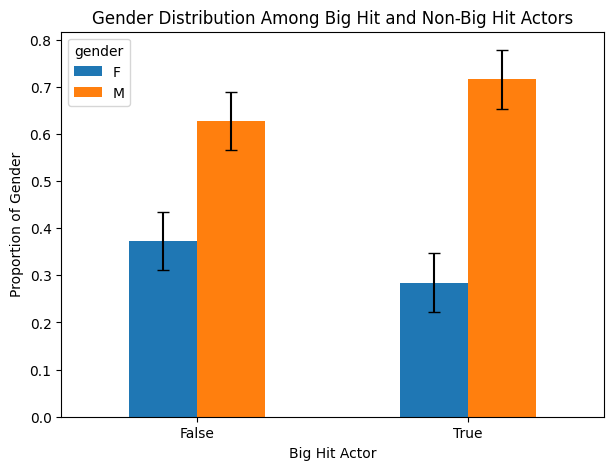

In [8]:
# Grouping by 'big_hit_actor' and 'gender' and counting
grouped = df_prepared.groupby(['big_hit_actor', 'gender']).size().unstack()

# Calculating proportions within each 'big_hit_actor' group
grouped_proportions = grouped.div(grouped.sum(axis=1), axis=0)

# Calculating standard deviation across 'big_hit_actor' groups for each gender
std_dev = grouped_proportions.std(axis=0)

# Preparing the DataFrame for error bars
error = pd.DataFrame([std_dev, std_dev], index=grouped_proportions.index)

# Plotting
ax = grouped_proportions.plot(kind='bar', yerr=error, figsize=[7, 5], rot=0, capsize=4)
ax.set_title('Gender Distribution Among Big Hit and Non-Big Hit Actors')
ax.set_ylabel('Proportion of Gender')
ax.set_xlabel('Big Hit Actor')
plt.show()

The chart shows that there are more men than women in both hit movies and less popular ones, with an even bigger difference in the hits. There's a wider range of success among men in hit movies, as shown by the longer error bars. Women's numbers are more stable but lower overall. This means gender could be a key factor to look at when studying the difference between actors in big hits and those in other movies.

Now let's have look at the repartition of the age at the peak of the acotrs carrier. We define the peak of one actor's carrier by the year where the product of the number of movies played in with their respective success metric is the highest.

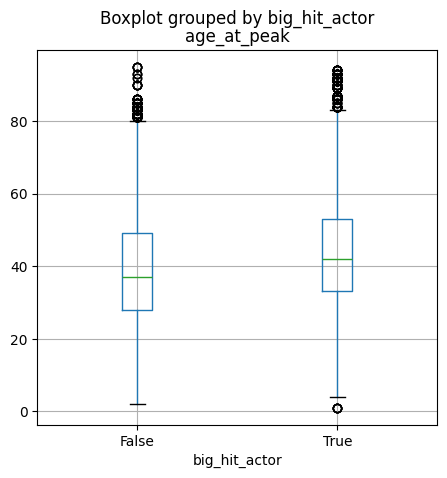

In [9]:
# Calculate the product of the number of movies and respective success metric for each actor and year
df_prepared['product'] = df_prepared.groupby(['name_actor', 'year']).movieID.transform('count') * df_prepared.success

# Find the row with the maximum product for each actor
max_product_rows = df_prepared.loc[df_prepared.groupby('name_actor')['product'].idxmax()]

# Extract the actor and the corresponding year for the maximum product
result = max_product_rows.loc[:, ['name_actor', 'year', 'birth']]

# Create a column in the dataframe with the age of the actors at their carrier peak:
result['age_at_peak'] = result['year'] - result['birth'].dt.year
result['year_of_peak'] = result['year']
df_prepared = pd.merge(df_prepared, result[['name_actor', 'age_at_peak', 'year_of_peak']], on='name_actor', how='left')


# Remove the product column
df_prepared = df_prepared.drop(columns = 'product')

# Visualize distribution

df_prepared.boxplot(by='big_hit_actor', column='age_at_peak', figsize = [5, 5], grid=True)
plt.show()

The boxplot shows that actors in big hits usually hit their peak at an older age than those who don't star in big hits. The ages are more grouped together for big hit actors, while there's a wider spread for the others. There are quite a few actors who peak at ages that are much higher or lower than average, especially among those without a big hit. This age at peak could be a good factor to look at when comparing actors in big hits versus others.

## 2. Matching

In [10]:
# Remove duplicate rows (actors that had multiple roles in the same movie)
df_prepared = df_prepared.drop_duplicates(subset=['movieID', 'releaseDate', 'name_actor'])

In [11]:
df_prepared['is_big_hit'] = df_prepared.movieID.isin(unique_movie_hits.movieID)
big_hit_actors_df = df_prepared[df_prepared['big_hit_actor'] & df_prepared['is_big_hit']]

# Find the year of the first big hit for each actor
first_big_hit_year = big_hit_actors_df.groupby('name_actor')['releaseDate'].min().reset_index()

# Merge the information back into the original DataFrame
df_prepared = pd.merge(df_prepared, first_big_hit_year, on='name_actor', how='left', suffixes=('', '_first_big_hit'))


In [12]:
# Count the number of unique movies each actor has played in
movies_per_actor = df_prepared.groupby('name_actor')['movieID'].nunique()

# Convert the Series to a DataFrame and reset the index
movies_per_actor_df = movies_per_actor.reset_index()
movies_per_actor_df.columns = ['name_actor', 'movie_count']

# Merge with the main DataFrame to associate the movie count with the big_hit_actor bool
df_prepared = df_prepared.merge(movies_per_actor_df, on='name_actor')

In [13]:
# Create a new DataFrame for big hit actors
big_hit_actors = df_prepared[df_prepared['big_hit_actor'] == True]

# Group by actor's name and calculate movie count before first big hit
movie_count_before_hit = big_hit_actors.groupby('name_actor').apply(lambda x: x[x['releaseDate'] < x['releaseDate_first_big_hit']]['movieID'].nunique())

# Convert the Series to a DataFrame and reset index
movie_count_before_hit = movie_count_before_hit.reset_index(name='movie_count_before_hit')

# Merge this count back into the original DataFrame
df_prepared = pd.merge(df_prepared, movie_count_before_hit, on='name_actor', how='left')

# Set the count to NaN for actors who are not big hit actors
df_prepared.loc[df_prepared['big_hit_actor'] == False, 'movie_count_before_hit'] = np.nan


In [14]:
# Create a new DataFrame from the drop_duplicates result
unique_actors = df_prepared.drop_duplicates(subset='name_actor').copy()

# Convert the 'big_hit_actor' column to int
unique_actors['big_hit_actor'] = unique_actors['big_hit_actor'].astype(int)



In [15]:
actors_big_hit = unique_actors[unique_actors['big_hit_actor'] == 1][['age_at_peak', 'gender', 'movie_count_before_hit']]
# Get a dataframe of actors that did not play in a big hit (control group)
actors_no_big_hit = unique_actors[unique_actors['big_hit_actor'] == 0][['age_at_peak', 'gender', 'movie_count']]

In [16]:
actors_big_hit = actors_big_hit.reset_index()
actors_big_hit_numpy = actors_big_hit.to_numpy()
treat_indices = actors_big_hit_numpy[:, 0]


actors_no_big_hit = actors_no_big_hit.reset_index()
actors_no_big_hit_numpy = actors_no_big_hit.to_numpy()
control_indices = actors_no_big_hit_numpy[:, 0]

# Creating an empty graph
B = nx.Graph()

# Adding nodes for the treatment group
B.add_nodes_from(treat_indices, bipartite=0)
# Adding nodes for the control group
B.add_nodes_from(control_indices, bipartite=1)

th = 3

for t_row in actors_big_hit_numpy:
    for c_row in actors_no_big_hit_numpy:
        if abs(t_row[1]-c_row[1]) <=10 and t_row[2] == c_row[2] and c_row[3]-t_row[3]>=th:
            # Adding an edge between treatment and control nodes with the total cost as weight
            B.add_edge(t_row[0], c_row[0], weight=0)


matching = nx.algorithms.matching.min_weight_matching(B)


In [17]:
len(matching)

3000

In [18]:
# Creating a new DataFrame to store the matched pairs with names
matched_df = pd.DataFrame(columns=['control_index', 'name_actor_control', 'treat_index', 'name_actor_treat'])

for control_idx, treatment_idx in matching:
    control_name = unique_actors.loc[control_idx]['name_actor']
    treatment_name = unique_actors.loc[treatment_idx]['name_actor']
    new_row = pd.DataFrame({
        'control_index': control_idx,
        'name_actor_control': control_name,
        'treat_index': treatment_idx,
        'name_actor_treat': treatment_name
    }, index=[0])
    matched_df = pd.concat([matched_df, new_row], axis=0, ignore_index=True)

matched_df

,control_index,name_actor_control,treat_index,name_actor_treat
0,53547,Michelle Johnson,17928,Catherine Mary Stewart
1,51467,Maggie Grace,25174,Irina Voronina
2,35185,Robert Pastorelli,50840,James Marsters
3,53020,Vanessa Branch,20626,Mira Sorvino
4,52885,Willard E. Pugh,54324,Zach Cregger
...,...,...,...,...
2995,46349,Thomas Haden Church,39698,Titus Welliver
2996,38732,Clifton James,52215,Kevin Sorbo
2997,59228,Gavin O'Herlihy,57174,Ben Browder
2998,37098,Paul Shaffer,49339,Jack Gwaltney


In [19]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df = unique_actors.loc[matched]


In [20]:
%store balanced_df
%store df_prepared
%store matched_df

Stored 'balanced_df' (DataFrame)
Stored 'df_prepared' (DataFrame)
Stored 'matched_df' (DataFrame)
